### Trade with XGBoost algorithm
### Background
In the [portfolio trade example](https://github.com/rapidsai/gQuant/blob/master/notebook/05_customize_nodes.ipynb), we use gQuant to backtest a simple mean reversion trading strategy on 5000 stocks.
It shows decent performance by tweaking the moving average window size. Searching for alpha signal is the ultimate goal for the trading companies. A lot of different methods are used to do so. Machine learning approach
is one of those. It has the benefits of extracting important information in the data automatically given enough computation. There are a few popular machine learning algrithoms, including SVM, Random forest tree etc. Amoung those, XGBoost is known to be a very powerful machine 
learning method that is winning a lot of [ML competitions](https://medium.com/syncedreview/tree-boosting-with-xgboost-why-does-xgboost-win-every-machine-learning-competition-ca8034c0b283). Luckily, the [RAPIDS library](https://github.com/rapidsai) accelerates the XGBoost ML algorithm in the GPU so that we can easily take advantage of it in the gQuant. 

In this notebook, we are going to demo how to use gQuant to backtest a XGBoost based trading stragty.


### Environment Preparation

In [1]:
import sys
sys.path.append('..')

import warnings
from gquant.dataframe_flow import run, load_workflow, viz_graph, Node, build_workflow
import nxpd
import ipywidgets as widgets
from nxpd import draw
import os

warnings.simplefilter("ignore")

Define some constants for the data filters. If using GPU of 32G memory, you can safely set the min_volume to 5.0

In [2]:
min_volume = 400.0
min_rate = -10.0
max_rate = 10.0

### The toy example
To mimic the end-to-end quantitative analyst task, we are going to backtest a XGBoost trading strategy. The workflow includes following steps:

1. Load the 5000 end-of-day stocks CSV data into the dataframe

2. Add rate of return feature to the dataframe.

3. Clean up the data by removing low volume stocks and extreme rate of returns stocks.

4. Compute the features based on different technical indicators 

5. Split the data in training and testing and build a XGBoost model based on the training data. From the XGBoost model, compute the trading signals for all the data points.

5. Run backtesting and compute the returns from this strategy for each of the days and stock symbols 

6. Run a simple portfolio optimization by averaging the stocks together for each of the trading days.

7. Compute the sharpe ratio and cumulative return results for both training and testing datasets

The whole workflow can be organized into a computation graph, which are fully described in a yaml file. Here is snippet of the yaml file:

In [3]:
!head -n 29 ../task_example/xgboost_trade.ymal

- id: node_csvdata
  type: CsvStockLoader
  conf:
    path: ./data/stock_price_hist.csv.gz
  inputs: []
- id: node_sort
  type: SortNode
  conf:
    keys:
      - asset
      - datetime
  inputs:
    - node_csvdata
- id: node_addReturn
  type: ReturnFeatureNode
  conf: {}
  inputs:
    - node_sort
- id: node_addIndicator
  type: AssetIndicatorNode
  conf: {}
  inputs:
    - node_addReturn
- id: node_volumeMean
  type: AverageNode
  conf:
    column: volume
  inputs: 
    - node_addIndicator


Each nodes has a unique id, a node type, configuration parameters and input nodes ids. gQuant takes this yaml file, wires it into a graph to visualize it.

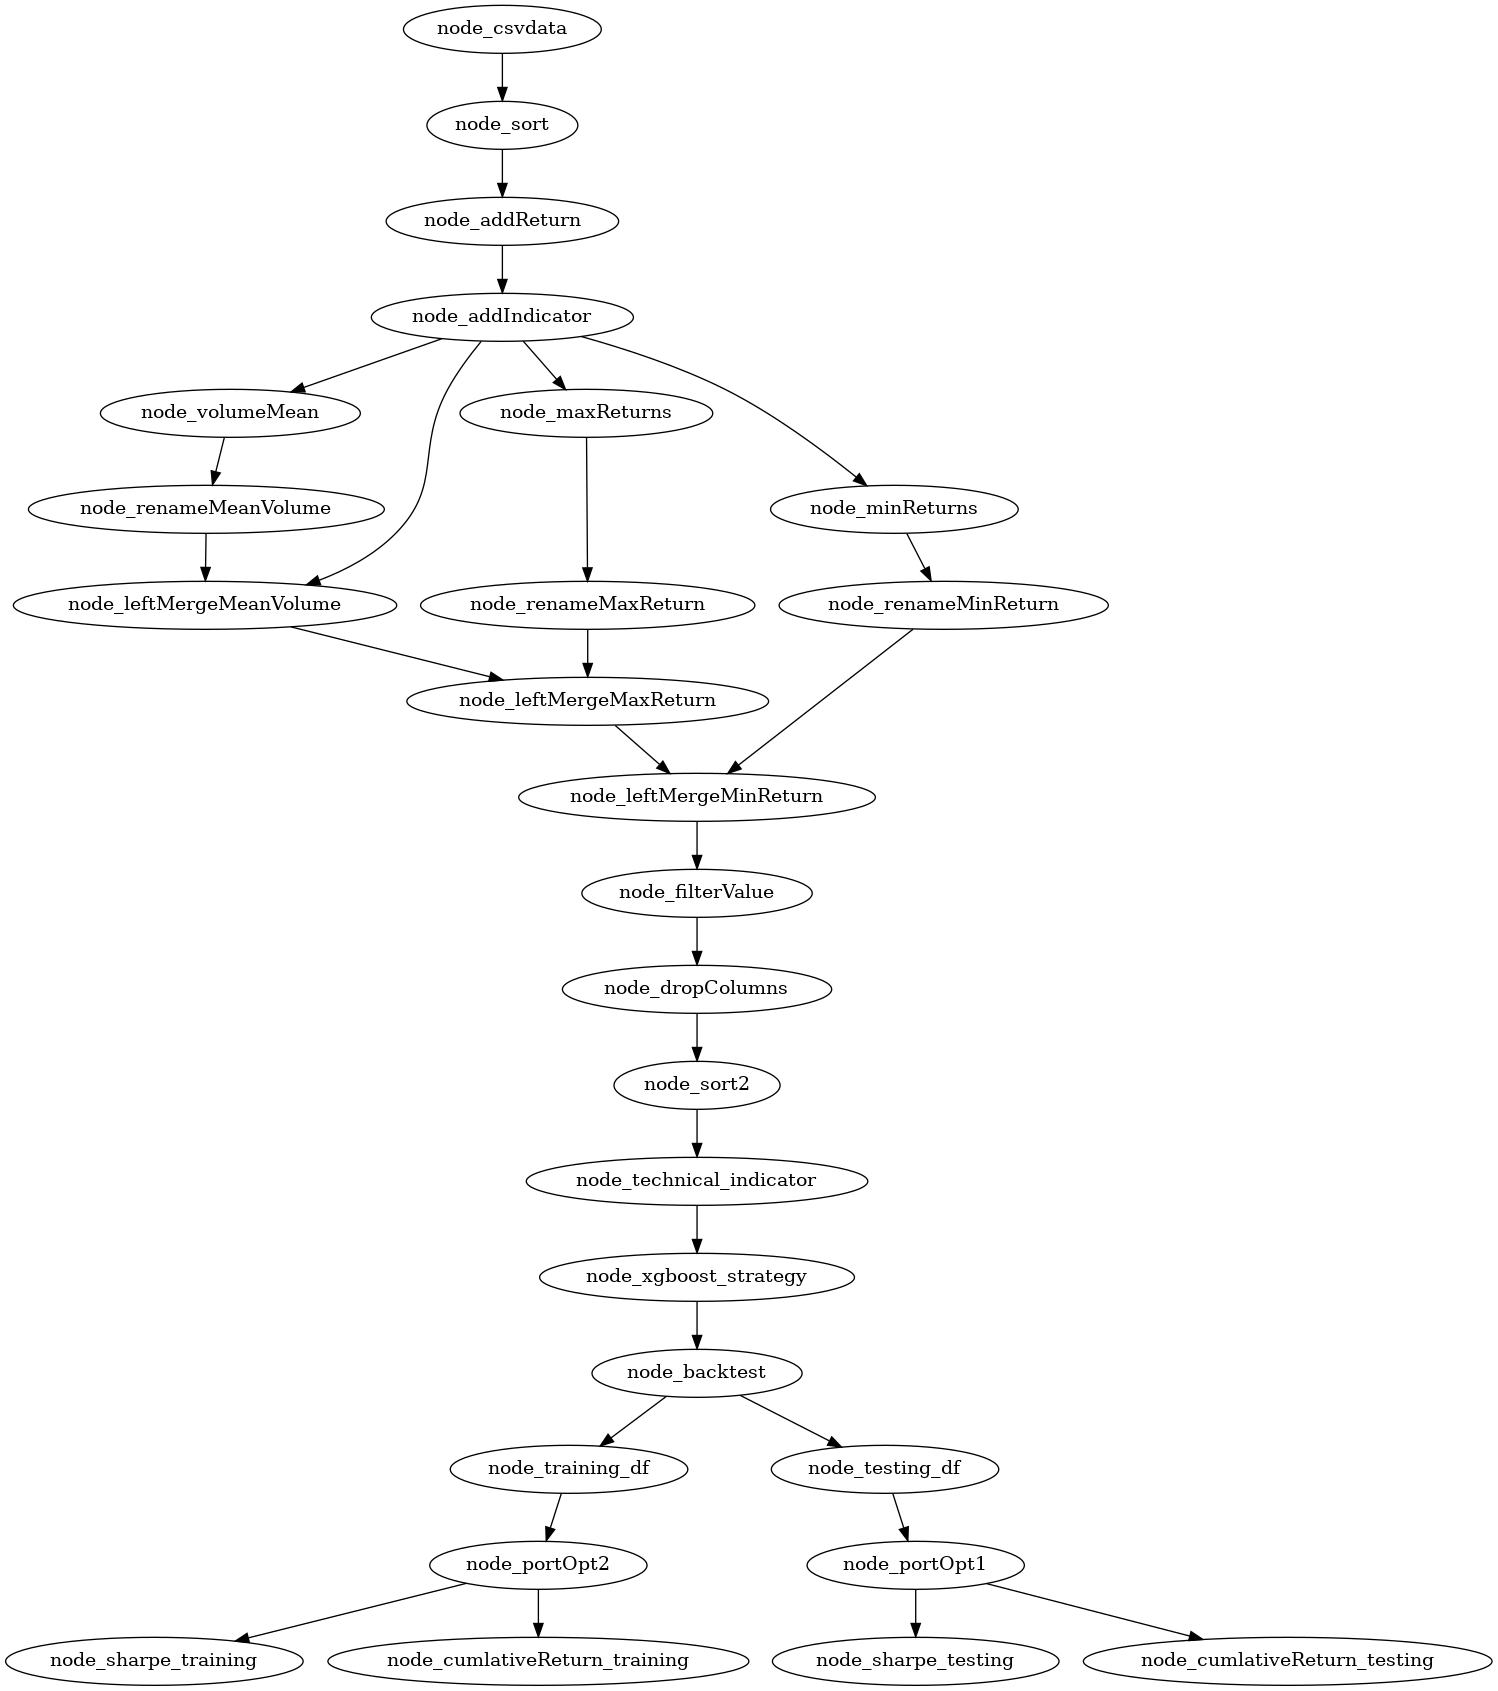

In [4]:
graph_obj = load_workflow('../task_example/xgboost_trade.ymal')
G = viz_graph(graph_obj)
draw(G, show='ipynb')

### gQuant Result and Benchmark
Similar to tensorflow, gQuant graph is evaluated by specifying the output nodes and input nodes replacement. We first look at the column result from data preparation node.

In [5]:
from pprint import pprint

task_dict = build_workflow(graph_obj)
print('Output columns of node node_technical_indicator:')
pprint(task_dict['node_technical_indicator'].output_columns)

Output columns of node node_technical_indicator:
{'BO_BA_b1_10': 'float64',
 'BO_BA_b2_10': 'float64',
 'CH_OS_10_20': 'float64',
 'SHIFT_-1': 'float64',
 'asset': 'int64',
 'close': 'float64',
 'datetime': 'datetime64[ms]',
 'high': 'float64',
 'indicator': 'int32',
 'low': 'float64',
 'open': 'float64',
 'returns': 'float64',
 'volume': 'float64'}


It adds the columns "BO_BA_b1_10", "BO_BA_b2_10", 'CH_OS_10_20" as features and "SHFIT_-1" as the target, which is the return of next day. A good feature should be the one that provides highest information about the next day return. In the case we have no prior information about it,
we can compute as many features as we like and leave it to the XGBoost to find the right combination of those features. 

Evaluate the leaf nodes of the backtesting graph by gQuant `run` method.

In [15]:
action = "load" if os.path.isfile('./.cache/node_csvdata.hdf5') else "save"
o_gpu = run(graph_obj,
            outputs=['node_sharpe_training','node_cumlativeReturn_training', 'node_sharpe_testing', 'node_cumlativeReturn_testing', 'node_sort2'],
            replace={'node_filterValue': {"conf": [{"column": "volume_mean", "min": min_volume},
                                                   {"column": "returns_max", "max": max_rate},
                                                   {"column": "returns_min", "min": min_rate}]},
                     'node_csvdata': {action: True}})
cached_sort = o_gpu[4]

cumulative return 5160 17
cumulative return 1655 5


Define a function to organized the plot results. 

In [16]:
# define the function to format the plots
def plot_figures(o):
    # format the figures
    figure_width = '1200px'
    figure_height = '400px'
    sharpe_number = o[0]
    cum_return_train = o[1]
    cum_return_train.layout.height = figure_height
    cum_return_train.layout.width = figure_width
    cum_return_train.title = 'Training P & L %.3f' % (sharpe_number)
    sharpe_number = o[2]
    cum_return_test = o[3]
    cum_return_test.layout.height = figure_height
    cum_return_test.layout.width = figure_width
    cum_return_test.title = 'Testing P & L %.3f' % (sharpe_number)

    return widgets.VBox([cum_return_train, cum_return_test])
plot_figures(o_gpu)

Clearly, 3 feautres is way too little here. gQuant implmented 36 technical indicators. We can change the configuration of node_technical_indicator node to include more features.

In [57]:
chaikin_para0 = 10
chaikin_para1 = 20
bollinger_para = 10
macd_para0 = 2
macd_para1 = 3
rsi_para0 = 5
atr_para0 = 10
sod_para = 2
mflow_para = 3
findex_para = 5
adis_para = 5
ccindex_para = 5
bvol_para = 3
vindex_para = 3
mindex_para0 = 10
mindex_para1 = 15
tindex_para0 = 5
tindex_para1 = 10
emove_para = 5
cc_para = 15
kchannel_para = 10
indicator_conf = {
    "indicators": [
        {"function": "port_chaikin_oscillator",
         "columns": ["high", "low", "close", "volume"],
         "args": [chaikin_para0, chaikin_para1]
        },
        {"function": "port_bollinger_bands",
         "columns": ["close"],
         "args": [bollinger_para],
         "outputs": ["b1", "b2"]
        },
        {"function": "port_macd",
         "columns": ["close"],
         "args": [macd_para0, macd_para1],
         "outputs": ["MACDsign", "MACDdiff"]
        },
        {"function": "port_relative_strength_index",
         "columns": ["high", "low"],
         "args": [rsi_para0],
        },
        {"function": "port_average_true_range",
         "columns": ["high", "low", "close"],
         "args": [atr_para0],
        },
        {"function": "port_stochastic_oscillator_k",
         "columns": ["high", "low", "close"],
         "args": [],
        },
        {"function": "port_stochastic_oscillator_d",
         "columns": ["high", "low", "close"],
         "args": [sod_para],
        },
        {"function": "port_money_flow_index",
         "columns": ["high", "low", "close", "volume"],
         "args": [mflow_para],
        },
        {"function": "port_force_index",
         "columns": ["close", "volume"],
         "args": [findex_para],
        },
        {"function": "port_ultimate_oscillator",
         "columns": ["high","low","close"],
         "args": [],
        },
        {"function": "port_accumulation_distribution",
         "columns": ["high","low","close","volume"],
         "args": [adis_para],
        },
        {"function": "port_commodity_channel_index",
         "columns": ["high","low","close"],
         "args": [ccindex_para],
        },
        {"function": "port_on_balance_volume",
         "columns": ["close", "volume"],
         "args": [bvol_para],
        },
        {"function": "port_vortex_indicator",
         "columns": ["high", "low", "close"],
         "args": [vindex_para],
        },
         {"function": "port_kst_oscillator",
         "columns": ["close"],
         "args": [3, 4, 5, 6, 7, 8, 9, 10],
        },
        {"function": "port_mass_index",
         "columns": ["high", "low"],
         "args": [mindex_para0, mindex_para1],
        },
        {"function": "port_true_strength_index",
         "columns": ["close"],
         "args": [tindex_para0, tindex_para1],
        },
        {"function": "port_ease_of_movement",
         "columns": ["high", "low", "volume"],
         "args": [emove_para],
        },
        {"function": "port_coppock_curve",
         "columns": ["close"],
         "args": [cc_para],
        },
        {"function": "port_keltner_channel",
         "columns": ["high", "low", "close"],
         "args": [kchannel_para],
         "outputs": ["KelChD", "KelChM", "KelChU"]
        },
        {"function": "port_ppsr",
         "columns": ["high", "low", "close"],
         "args": [],
         "outputs": ["PP", "R1", "S1", "R2", "S2", "R3", "S3"]
        },
        {"function": "port_shift",
         "columns": ["returns"],
         "args": [-1]
        }        
    ],
    "remove_na": True
}

Run the backtesting again

In [ ]:
action = "load" if os.path.isfile('./.cache/node_csvdata.hdf5') else "save"
o_gpu = run(graph_obj,
            outputs=['node_sharpe_training','node_cumlativeReturn_training', 'node_sharpe_testing', 'node_cumlativeReturn_testing'],
            replace={'node_filterValue': {"conf": [{"column": "volume_mean", "min": min_volume},
                                                   {"column": "returns_max", "max": max_rate},
                                                   {"column": "returns_min", "min": min_rate}]},
                     "node_technical_indicator": {"conf": indicator_conf},
                     "node_sort2": {"load": cached_sort},
                     'node_csvdata': {action: True}})
plot_figures(o_gpu)

We get Sharpe Raio of `1.93` in the testing dataset, not bad!

In [ ]:
## Strategy parameter search
Quantitative analyst usually need to explore different parameters for their trading strategy. The exploration process is an iterative process. gQuant help to speed up this by allowing using cached dataframe and evaluating the sub-graphs.

To find the optimal technical indicator parameters for this XGBoost strategy, we build a wiget to search the parameter interactively. 

In [149]:

chaikin_para0 = 10
chaikin_para1 = 20
bollinger_para = 10
macd_para0 = 2
macd_para1 = 3
rsi_para0 = 5
atr_para0 = 10
sod_para = 2
mflow_para = 3
findex_para = 5
adis_para = 5
ccindex_para = 5
bvol_para = 3
vindex_para = 3
mindex_para0 = 10
mindex_para1 = 15
tindex_para0 = 5
tindex_para1 = 10
emove_para = 5
cc_para = 15
kchannel_para = 10

def getRangeSlider(val0, val1, des=""):
    return  widgets.IntRangeSlider(value=[val0, val1],
                                       min=1,
                                       max=60,
                                       step=1,
                                       description=des,
                                       disabled=False,
                                       continuous_update=False,
                                       orientation='horizontal',
                                       readout=True)


def getSlider(val, des=""):
    return widgets.IntSlider(value=val,
                             min=1,                         
                             max=60,
                             step=1,
                             description=des,
                             disabled=False,
                             continuous_update=False,
                             orientation='horizontal',
                             readout=True,
                             readout_format='d')

out = widgets.Output(layout={'border': '1px solid black'})

with out:
    chaikin_selector = getRangeSlider(chaikin_para0, chaikin_para1, "Chaikin")
    def chaikin_selection(*stocks):
        with out:
            global chaikin_para0
            global chaikin_para1
            chaikin_para0 = chaikin_selector.value[0]
            chaikin_para1 = chaikin_selector.value[1]
    chaikin_selector.observe(chaikin_selection, 'value')
    
    bollinger_selector = getSlider(bollinger_para, "bollinger")
    def bollinger_selection(*stocks):
        with out:
            global bollinger_para
            bollinger_para = bollinger_selector.value
    bollinger_selector.observe(bollinger_selection, 'value')
    
    macd_selector = getRangeSlider(chaikin_para0, chaikin_para1, "MACD")
    def macd_selection(*stocks):
        with out:
            global macd_para0
            global macd_para1
            macd_para0 = macd_selector.value[0]
            macd_para1 = macd_selector.value[1]
    macd_selector.observe(macd_selection, 'value')
    
    rsi_selector = getSlider(rsi_para0, "Relative Str")
    def rsi_selection(*stocks):
        with out:
            global rsi_para0
            rsi_para0 = rsi_selector.value
    rsi_selector.observe(rsi_selection, 'value')


    atr_selector = getSlider(atr_para0, "ATR")
    def atr_selection(*stocks):
        with out:
            global atr_para0
            atr_para0 = atr_selector.value
    atr_selector.observe(atr_selection, 'value')
    
    
    sod_selector = getSlider(sod_para, "Sto Osc")
    def sod_selection(*stocks):
        with out:
            global sod_para
            sod_para = sod_selector.value
    sod_selector.observe(sod_selection, 'value')
    
    mflow_selector = getSlider(mflow_para, "Money F")
    def mflow_selection(*stocks):
        with out:
            global mflow_para
            mflow_para = mflow_selector.value
    mflow_selector.observe(mflow_selection, 'value')
    
    adis_selector = getSlider(adis_para, "Ave DMI")
    def adis_selection(*stocks):
        with out:
            global adis_para
            adis_para = adis_selector.value
    adis_selector.observe(adis_selection, 'value')

    ccindex_selector = getSlider(ccindex_para, "Comm Cha")
    def ccindex_selection(*stocks):
        with out:
            global ccindex_para
            ccindex_para = ccindex_selector.value
    ccindex_selector.observe(ccindex_selection, 'value')
    
    bvol_selector = getSlider(bvol_para, "On Balance")
    def bvol_selection(*stocks):
        with out:
            global bvol_para
            bvol_para = bvol_selector.value
    bvol_selector.observe(bvol_selection, 'value')
    
    
    vindex_selector = getSlider(vindex_para, "Vortex")
    def vindex_selection(*stocks):
        with out:
            global vindex_para
            vindex_para = vindex_selector.value
    vindex_selector.observe(vindex_selection, 'value')
    
    mindex_selector = getRangeSlider(mindex_para0, mindex_para1, "Mass Index")
    def mindex_selection(*stocks):
        with out:
            global mindex_para0
            global mindex_para1
            mindex_para0 = mindex_selector.value[0]
            mindex_para1 = mindex_selector.value[1]
    mindex_selector.observe(mindex_selection, 'value')
    
    tindex_selector = getRangeSlider(tindex_para0, tindex_para1, "True Strength")
    def tindex_selection(*stocks):
        with out:
            global tindex_para0
            global tindex_para1
            tindex_para0 = tindex_selector.value[0]
            tindex_para1 = tindex_selector.value[1]
    tindex_selector.observe(tindex_selection, 'value')
    
    emove_selector = getSlider(emove_para, "Easy Move")
    def emove_selection(*stocks):
        with out:
            global emove_para
            emove_para = emove_selector.value
    emove_selector.observe(emove_selection, 'value')
    
    cc_selector = getSlider(cc_para, "Cppock Curve")
    def cc_selection(*stocks):
        with out:
            global cc_para
            cc_para = cc_selector.value
    cc_selector.observe(cc_selection, 'value')

    kchannel_selector = getSlider(kchannel_para, "Keltner Channel")
    def kchannel_selection(*stocks):
        with out:
            global kchannel_para
            kchannel_para = kchannel_selector.value
    kchannel_selector.observe(kchannel_selection, 'value')
    
    button = widgets.Button(
    description='Compute',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me')
 

    def on_button_clicked(b):
        with out:
            print("Button clicked.")
            w.children = (w.children[0], widgets.Label("Busy...."),)
            action = "load" if os.path.isfile('./.cache/node_csvdata.hdf5') else "save"
            o_gpu = run(graph_obj, outputs=['node_sharpe_training','node_cumlativeReturn_training', 'node_sharpe_testing', 'node_cumlativeReturn_testing'],
                                   replace={'node_filterValue': {"conf": [{"column": "volume_mean", "min": min_volume},
                                                                          {"column": "returns_max", "max": max_rate},
                                                                          {"column": "returns_min", "min": min_rate}]},
                                            "node_technical_indicator": {"conf": indicator_conf},
                                            "node_sort2": {"load": cached_sort},
                                            'node_csvdata': {action: True}})
            figure_combo = plot_figures(o_gpu)
            w.children = (w.children[0], figure_combo,)
    button.on_click(on_button_clicked)
    
    
selectors = widgets.VBox([chaikin_selector, bollinger_selector, macd_selector, rsi_selector, atr_selector, sod_selector, mflow_selector, adis_selector, ccindex_selector, bvol_selector, vindex_selector, mindex_selector, tindex_selector, emove_selector, cc_selector, kchannel_selector, button])
w = widgets.VBox([selectors])
w

### Conclusions
In this notebook, we demoed how to use gQuant to backtest XGBoost trading strategy. It is convenient and efficient to use indicator node from the gQuant to compute features for all the stocks in the dataset in the GPU. The XGBoost training are computed in the GPU, so we can get the results quickly. This example shows the XGBoost algorithm's power in finding trading signals. We can achieve close to 2 raw Sharpe ratio in the testing time period.